In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import ortho_group
import os
import sys
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from skimage.transform import AffineTransform, warp
from torch.autograd import Variable

from scipy import stats

from __future__ import print_function
#%matplotlib inline
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image, ImageDraw
import traceback

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Size of z latent vector (i.e. size of generator input)
nz = 100

ndf = 64
ngf = 64

In [ ]:
def plot_gallery(list_images, h, w, n_row=3, n_col=6, flat_list = False):
    """Helper function to save a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row):
        for j in range(n_col):    
            plt.subplot(n_row, n_col, i * n_col + j + 1)
            if flat_list:
                plt.imshow(list_images[i*n_col + j].reshape((h, w)).numpy().astype(np.int), cmap='Greys')
            else:
                plt.imshow(list_images[j][i].reshape((h, w)).numpy().astype(np.int), cmap='Greys')
            plt.xticks(())
            plt.yticks(())

In [ ]:
def draw_figure(size=128, size_of_is=60, pre_def = None, is_is=True):
    if not pre_def is None:
        s = pre_def[0]
    else:
        s = int((np.random.sample(1)[0] * 0.8 + 0.2) * size_of_is)
    
    a = np.array([s/2,  s/2], dtype=np.int)
    
    if not pre_def is None:
        c = np.array(pre_def[1:])
    else:
        c = np.random.randint(s/2, size - s/2, size=2)
    
    out = Image.new("L", (size, size), (0))
    d = ImageDraw.Draw(out)

    if is_is:
        d.ellipse(  np.concatenate([c-a, c+a]).tolist(), outline=(255), width=3)
    else:
        d.rectangle(np.concatenate([c-a, c+a]).tolist(), outline=(255), width=3)
    
    return out, [s, c[0], c[1]]

In [ ]:
class ImageDataset(Dataset):
    
    def __init__(self, draw_function, lenght = 512, t=lambda x : x):
        super().__init__()
        self.lenght = lenght
        self.draw_function = draw_function
        self.t = t

        # imgs  = [None] * lenght
        # infos = [None] * lenght

        # for i in range(lenght):
        #     img, r = draw_function()

        #     imgs[i] = t(img)
        #     infos[i] = torch.Tensor(r)
        
        # self.imgs  = torch.vstack(imgs)
        # self.infos = torch.vstack(infos)

    def __getitem__(self, idx):
        # return self.imgs[idx], self.infos[idx]
        img, r = self.draw_function()

        return self.t(img), torch.Tensor(r)
    
    def __len__(self):
        # return len(self.data)
        return self.lenght

In [ ]:
t = transforms.Compose([transforms.GaussianBlur(11),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5), (0.5)),
                       ])

is_data = ImageDataset(lambda : draw_figure(is_is=True ), lenght = 30000, t=t)
lb_data = ImageDataset(lambda : draw_figure(is_is=False), lenght = 30000, t=t)

is_val_data = ImageDataset(lambda : draw_figure(is_is=True ), lenght = 3000, t=t)
lb_val_data = ImageDataset(lambda : draw_figure(is_is=False), lenght = 3000, t=t)

is_loader = torch.utils.data.DataLoader(is_data, batch_size=512, num_workers=2)
lb_loader = torch.utils.data.DataLoader(lb_data, batch_size=512, num_workers=2)

is_val_loader = torch.utils.data.DataLoader(is_val_data, batch_size=512, num_workers=2)
lb_val_loader = torch.utils.data.DataLoader(lb_val_data, batch_size=512, num_workers=2)
print(len(is_data), len(lb_data))

is_image_h = 64
is_image_w = 64

30000 30000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


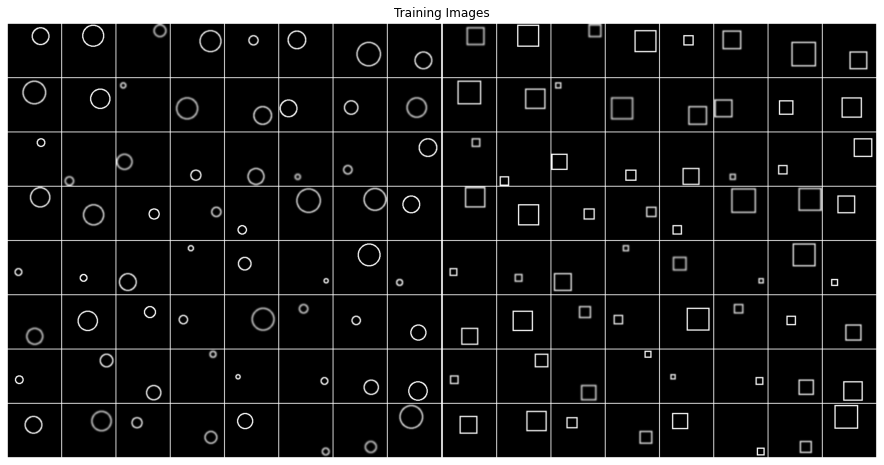

In [ ]:
is_batch = next(iter(is_loader))
lb_batch = next(iter(lb_loader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.hstack([np.transpose(vutils.make_grid(is_batch[0][:64], padding=2, pad_value=255, normalize=True).cpu(),(1,2,0)),
                      np.transpose(vutils.make_grid(lb_batch[0][:64], padding=2, pad_value=255, normalize=True).cpu(),(1,2,0))]))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.down = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.up = nn.Sequential(
            nn.ConvTranspose2d(1, ndf * 8, 4, 1, 0, bias=False),
            # state size. (ndf*8) x 4 x 4
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 8),
            nn.ConvTranspose2d(ndf * 8, ndf * 4, 4, 2, 1, bias=False),
            # state size. (ndf*4) x 8 x 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 4),
            nn.ConvTranspose2d(ndf * 4, ndf * 2, 4, 2, 1, bias=False),
            # state size. (ndf*2) x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 2),
            nn.ConvTranspose2d(ndf * 2, ndf, 4, 2, 1, bias=False),
            # state size. (ndf) x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ndf, 1, 4, 2, 1, bias=False),
            # input is (nc) x 64 x 64
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        input = self.down(input)
        input = self.up(input)
        return input#.view(input.size(0), -1)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid(),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netE = Encoder().cuda()
netE.apply(weights_init)
netC = Classifier().cuda()
# netC.apply(weights_init)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()


# Setup RMSprop optimizers for both G and D
optimizerE = optim.RMSprop(netE.parameters())
optimizerC = optim.RMSprop(netC.parameters(), lr = 0.00005)

In [ ]:
def get_prior_A_for_classifier(x1, x2):
    assert x1.size(0) == x2.size(0)
    y = torch.cat([torch.full((x1.size(0),), -1, dtype=torch.float, device = x1.device), 
                   torch.full((x2.size(0),),  1, dtype=torch.float, device = x2.device)])
    x = torch.cat([x1, x2])

    ksi = Variable(torch.rand((x.size(0),), device = x.device), requires_grad=True)
    lam = Variable(torch.rand(96, device = x.device), requires_grad=True)

    opt = torch.optim.SGD([{"params": ksi, "lr": 0.1},
                           {"params": lam, "lr": 0.1},
                           ])

    for _ in range(100):
        opt.zero_grad()
        
        _A = torch.diag(lam) + (x.t() * (2 * torch.sigmoid(ksi) - 1) / (2 * ksi)).mm(x)
        v = torch.mv(x.t(), y) / 2
        sum = (2 * F.logsigmoid(ksi) + (2 * torch.sigmoid(ksi) - 1) * ksi / 2 - ksi).sum()
        sum += torch.log(lam).sum() - torch.logdet(_A) + torch.mv(torch.linalg.inv(_A), v).dot(v)

        (-sum).backward()
        opt.step()

    return lam.detach()

In [ ]:
def train_all():
    netE.train(); netC.train(); 
    E_losses = []
    C_losses = []
    lams = []
    iters = 0
    num_epochs = 10
    clip_value = 0.01

    print("Starting Training Loop...")
    # For each epoch
    try:
        for epoch in range(num_epochs):
            
            for _ in range(5):
                # For each batch in the dataloader
                for i, (is_data, lb_data) in enumerate(zip(is_loader, lb_loader), 0):
                    ############################
                    # (2) Update E network
                    ###########################
                    netE.zero_grad()
                    # Since we just updated C, perform another forward pass of all-fake batch through C

                    # Calculate E's loss based on this output
                    lb_data = lb_data[0].cuda()
                    lb_emb_data = netE(lb_data)
                    errE = -torch.mean(netC(lb_emb_data))
                    # Calculate gradients for E, D
                    errE.backward()
                    # Update E, D
                    optimizerE.step()

                    # Save Losses for plotting later
                    E_losses.append(errE.item())
                

            # For each batch in the dataloader
            for i, (is_data, lb_data) in enumerate(zip(is_loader, lb_loader), 0):

                ############################
                # (1) Update C network
                ###########################
                ## Train with all-real batch
                netC.zero_grad()
                # Format batch
                is_data = is_data[0].cuda()
                lb_data = lb_data[0].cuda()

                # Forward pass real batch through C
                lb_emb_data = netE(lb_data)

                # Calculate loss on 0-domain batch
                errC = -torch.mean(netC(is_data)) + torch.mean(netC(lb_emb_data.detach()))
                # Calculate gradients for C in backward pass
                errC.backward()
                optimizerC.step()

                # Clip weights of discriminator
                for p in netC.parameters():
                    p.data.clamp_(-clip_value, clip_value)
                
                ############################
                # (2) Update E network
                ###########################
                netE.zero_grad()
                # Since we just updated C, perform another forward pass of all-fake batch through C

                # Calculate E's loss based on this output
                errE = -torch.mean(netC(lb_emb_data))
                # Calculate gradients for E, D
                errE.backward()
                # Update E, D
                optimizerE.step()

                # Output training stats
                if i % 60 == 0:
                    print('[%d/%d][%d/%d]\tLoss_C: %.4f\tLoss_E: %.4f'
                        % (epoch, num_epochs, i, len(is_loader),
                            errC.item(), errE.item()))

                # Save Losses for plotting later
                E_losses.append(errE.item())
                C_losses.append(errC.item())
                
                # Check how the generator is doing by saving G's output on fixed_noise
                # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                #     with torch.no_grad():
                #         fake = netG(fixed_noise).detach().cpu()
                #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
            

            (is_data, lb_data) = next(iter( zip(is_val_loader, lb_val_loader) ))

            is_data = is_data[0].cuda()
            lb_data = lb_data[0].cuda()
            lb_emb_data = netE(lb_data)
            
            # l = get_prior_A_for_classifier(is_data.detach(), lb_emb_data.detach())
            # lams.append(l.cpu().detach().numpy().copy())
    except BaseException:
        traceback.print_exc()
    finally:
        return E_losses, C_losses, lams

res = train_all()
E_losses = res[0]; C_losses = res[1]; lams = res[2]

Starting Training Loop...
[0/10][0/59]	Loss_C: 0.0386	Loss_E: -0.4981
[1/10][0/59]	Loss_C: -0.0003	Loss_E: -0.4976
[2/10][0/59]	Loss_C: -0.0004	Loss_E: -0.4969
[3/10][0/59]	Loss_C: -0.0002	Loss_E: -0.4962
[4/10][0/59]	Loss_C: 0.0005	Loss_E: -0.4949
[5/10][0/59]	Loss_C: 0.0002	Loss_E: -0.4935
[6/10][0/59]	Loss_C: 0.0005	Loss_E: -0.4909
[7/10][0/59]	Loss_C: -0.0015	Loss_E: -0.4868
[8/10][0/59]	Loss_C: -0.0042	Loss_E: -0.4826
[9/10][0/59]	Loss_C: 0.0007	Loss_E: -0.4858


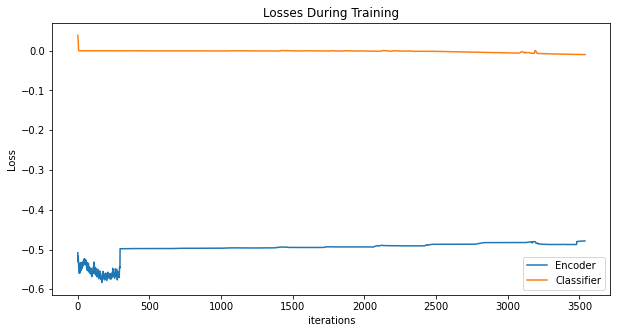

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Losses During Training")
plt.plot(E_losses,label="Encoder")
plt.plot(np.linspace(0, len(E_losses), len(C_losses)), C_losses, label="Classifier")
# plt.plot(D1_losses,label="Decoder 1")
# plt.plot(D2_losses,label="Decoder 2")
# plt.hlines(1.3863, -10, len(E_losses), linestyles='--', alpha=0.5, label='Random Classifier value')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(netE.state_dict(), 'netE_Wass')
torch.save(netC.state_dict(), 'netC_Wass')

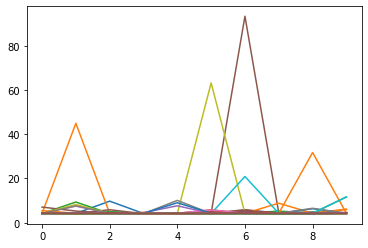

In [ ]:
_ = plt.plot(lams)

In [ ]:
class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(96, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
model = SimpleRegressor().cuda()
model_criterion = nn.MSELoss()

model_optimizer = optim.Adam(model.parameters())

In [ ]:
def calc_Aduenko_p_value(x1, y1, x2, y2):
    w_hat1 = torch.linalg.inv(x1.t().mm(x1)).mv(x1.t().mv(y1))
    w_hat2 = torch.linalg.inv(x2.t().mm(x2)).mv(x2.t().mv(y2))

    w_dif = w_hat1 - w_hat2
    s = torch.linalg.inv(x1.t().mm(x1)) + torch.linalg.inv(x2.t().mm(x2))
    value = torch.linalg.inv(s).mv(w_dif).dot(w_dif)

    return stats.chi2(96).cdf(value.item())

In [ ]:
def train_model():
    model.train()
    netE.eval()
    is_losses = []
    lb_losses = []
    iters = 0
    num_epochs = 50

    print("Starting Training Loop...")
    # For each epoch
    try:
        for epoch in range(num_epochs):
            for i, (is_data, lb_data) in enumerate(zip(is_loader, lb_loader), 0):
                ## Train with all-real batch
                model.zero_grad()
                # Format batch
                is_X_data = is_data[0].cuda()
                is_y_data = is_data[1].cuda() / 5

                lb_X_data = lb_data[0].cuda()
                lb_y_data = lb_data[1].cuda() / 5

                is_pred = model(is_X_data)
                # Calculate loss on 0-domain batch
                err = model_criterion(is_pred.view(-1), is_y_data)
                # Calculate gradients for D in backward pass
                err.backward()
                model_optimizer.step()
                
                # Output training stats
                if i % 60 == 0:
                    print('[%d/%d][%d/%d]\tLoss: %.4f'
                        % (epoch, num_epochs, i, len(is_loader),
                            err.item()))

                # Save Losses for plotting later
                is_losses.append(err.item())
                with torch.no_grad():
                    lb_losses.append(model_criterion(model(netE(lb_X_data)).view(-1), lb_y_data).item())
                
                # Check how the generator is doing by saving G's output on fixed_noise
                # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                #     with torch.no_grad():
                #         fake = netG(fixed_noise).detach().cpu()
                #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
    except BaseException:
        traceback.print_exc()
    finally:
        return is_losses, lb_losses

is_losses, lb_losses = train_model()

Starting Training Loop...
[0/50][0/59]	Loss: 0.2238
[1/50][0/59]	Loss: 0.1101
[2/50][0/59]	Loss: 0.0688
[3/50][0/59]	Loss: 0.0508
[4/50][0/59]	Loss: 0.0420
[5/50][0/59]	Loss: 0.0385
[6/50][0/59]	Loss: 0.0376
[7/50][0/59]	Loss: 0.0376
[8/50][0/59]	Loss: 0.0359
[9/50][0/59]	Loss: 0.0354
[10/50][0/59]	Loss: 0.0353
[11/50][0/59]	Loss: 0.0342
[12/50][0/59]	Loss: 0.0345
[13/50][0/59]	Loss: 0.0326
[14/50][0/59]	Loss: 0.0335
[15/50][0/59]	Loss: 0.0336
[16/50][0/59]	Loss: 0.0330
[17/50][0/59]	Loss: 0.0341
[18/50][0/59]	Loss: 0.0327
[19/50][0/59]	Loss: 0.0334
[20/50][0/59]	Loss: 0.0338
[21/50][0/59]	Loss: 0.0311
[22/50][0/59]	Loss: 0.0306
[23/50][0/59]	Loss: 0.0316
[24/50][0/59]	Loss: 0.0312
[25/50][0/59]	Loss: 0.0304
[26/50][0/59]	Loss: 0.0294
[27/50][0/59]	Loss: 0.0303
[28/50][0/59]	Loss: 0.0303
[29/50][0/59]	Loss: 0.0321
[30/50][0/59]	Loss: 0.0321
[31/50][0/59]	Loss: 0.0308
[32/50][0/59]	Loss: 0.0329
[33/50][0/59]	Loss: 0.0308
[34/50][0/59]	Loss: 0.0308
[35/50][0/59]	Loss: 0.0292
[36/50][0/59

In [ ]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5))
# plt.title("Loss During Training Wass")
plt.plot(np.array(is_losses).reshape(-1, 59).mean(1), label="I&S MSE", linewidth = 5)
plt.plot(np.array(lb_losses).reshape(-1, 59).mean(1), label="LB MSE",  linewidth = 5)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()